# step60 LSTM과 데이터 로더

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
my_path = '/content/notebooks'
# 구글드라이브 deep-learning-from-scratch-3-master 폴더에 있는 패키지를 colab에 심볼링크걸린 notebooks 폴더 생성 
os.symlink('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-3-master', my_path)
# 파이썬 모듈 검색 경로추가
sys.path.insert(0, my_path)

## 60.1 시계열 데이터용 데이터 로더

### 514 dataloaders.py

In [12]:
# dezero/dataloaders.py

from dezero import DataLoader
import numpy as np

class SeqDataLoader(DataLoader):
  def __init__(self, dataset, batch_size, gpu=False):
    super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, gpu=gpu)

  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()
      raise StopIteration
  
    jump = self.data_size // self.batch_size  # 추가
    batch_index = [(i * jump + self.iteration) % self.data_size for i in range(self.batch_size)]  # 추가
    batch = [self.dataset[i] for i in batch_index]  # 추가

    xp = cuda.cupy if self.gpu else np
    x = xp.array([example[0] for example in batch])
    t = xp.array([example[1] for example in batch])

    self.iteration += 1
    return x, t

### 515 사용예

In [13]:
import dezero  # 실행하기 위해서
train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t = next(dataloader)
print(x)
print('-----------------')
print(t)

[[-0.03169955]
 [ 0.91447061]
 [-0.85633874]]
-----------------
[[-0.03874369]
 [ 0.88659105]
 [-0.83230461]]


## 60.2 LSTM 계층 구현

### 515 수식

### 516 layers.py

In [18]:
# dezero/layers.py

from dezero import Layer  # 실행하기 위해서

class LSTM(Layer):
  def __init__(self, hidden_size, in_size=None):
    super().__init__()

    H, I = hidden_size, in_size
    self.x2f = Linear(H, in_size=I)
    self.x2i = Linear(H, in_size=I)
    self.x2o = Linear(H, in_size=I)
    self.x2u = Linear(H, in_size=I)
    self.h2f = Linear(H, in_size=H, nobias=True)
    self.h2i = Linear(H, in_size=H, nobias=True)
    self.h2o = Linear(H, in_size=H, nobias=True)
    self.h2u = Linear(H, in_size=H, nobias=True)

  def reset_state(self):
    self.h = None
    self.c = None

  def forward(self, x):
    self.h = None
    self.c = None
  
  def forward(self, x):
    if self.h is None:
      f = F.sigmoid(self.x2f(x))
      i = F.sigmoid(self.x2i(x))
      o = F.sigmoid(self.x2o(x))
      u = F.tanh(self.x2u(x))
    else:
      f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
      i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
      o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
      u = F.tanh(self.x2u(x) + self.h2u(self.h))

    if self.c is None:
      c_new = (i * u)
    else:
      c_new = (f * self.c) + (i * u)
      h_new = o * F.tanh(c_new)

      self.h, self.c = h_new, c_new
      return h_new

### 517~518 step60.py

In [21]:
# steps/step60.py

import numpy as np
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
# 시계열용 데이터 로더 사용
dataloader = SeqDataLoader(train_set, batch_size=batch_size)  # 추가
seqlen = len(train_set)

class BetterRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.LSTM(hidden_size)  # LSTM 사용 # 추가
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()
  
  def forward(self, x):
    y = self.rnn(x)
    y = self.fc(y)
    return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x, t in dataloader:
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1
    if count % bptt_length == 0 or count == seqlen:
      # dezero.utils.plot_dot_graph(loss)  # 계산 그래프 그리기
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()
  
  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.564665
| epoch 2 | loss 0.454792
| epoch 3 | loss 0.358419
| epoch 4 | loss 0.276318
| epoch 5 | loss 0.208705
| epoch 6 | loss 0.155221
| epoch 7 | loss 0.115232
| epoch 8 | loss 0.087862
| epoch 9 | loss 0.071750
| epoch 10 | loss 0.064788
| epoch 11 | loss 0.064204
| epoch 12 | loss 0.067104
| epoch 13 | loss 0.071038
| epoch 14 | loss 0.074228
| epoch 15 | loss 0.075565
| epoch 16 | loss 0.074572
| epoch 17 | loss 0.071313
| epoch 18 | loss 0.066258
| epoch 19 | loss 0.060090
| epoch 20 | loss 0.053544
| epoch 21 | loss 0.047272
| epoch 22 | loss 0.041764
| epoch 23 | loss 0.037317
| epoch 24 | loss 0.034035
| epoch 25 | loss 0.031859
| epoch 26 | loss 0.030610
| epoch 27 | loss 0.030043
| epoch 28 | loss 0.029897
| epoch 29 | loss 0.029931
| epoch 30 | loss 0.029954
| epoch 31 | loss 0.029839
| epoch 32 | loss 0.029517
| epoch 33 | loss 0.028977
| epoch 34 | loss 0.028242
| epoch 35 | loss 0.027362
| epoch 36 | loss 0.026397
| epoch 37 | loss 0.025403
| epoch 38

### LSTM 계층을 사용한 모델의 에측 결과

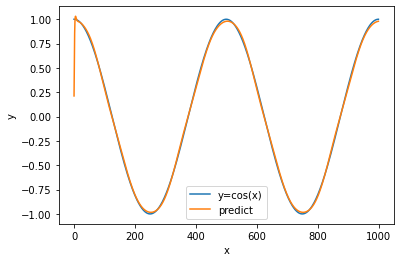

In [22]:
import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()  # 모델 재설정
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1, 1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()